## Importação das bibliotecas principais

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

## Carregamento dos dados e ajustes

Aqui estamos carregando os dados do dataset `sao-paulo-properties-april-2019.csv` disponível no link https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019

Após carregar estamos separando o dataset entre as colunas que vamos utilizar para predição (x) e a coluna que será a resposta (y)

In [2]:
df = pd.read_csv("./sao-paulo-properties-april-2019.csv")
df.iloc[:]

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13635,265000,420,51,2,1,0,1,0,0,0,0,Jabaquara/São Paulo,sale,apartment,-23.653004,-46.635463
13636,545000,630,74,3,2,1,2,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.648930,-46.641982
13637,515000,1100,114,3,3,1,1,0,0,1,0,Jabaquara/São Paulo,sale,apartment,-23.649693,-46.649783
13638,345000,48,39,1,2,1,1,0,1,1,0,Jabaquara/São Paulo,sale,apartment,-23.652060,-46.637046


## Separação das colunas

Esse dataset possui dados numéricos e categóricos. Nessa etapa estamos definindo quais colunas possuem dados numéricos e quais possuem os dados categóricos, pois eles precisam ser pre-processados de maneira diferente

In [3]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

## Criação do preprocessamento

Após fazer a separação entre dados categóricos e dados numéricos, vamos definir os pre-processadores para cada um desses dados

Para os dados categóricos fizemos a sua substituição utilizando o `LabelEncoder`, que irá criar um número correspondente para cada valor distinto na coluna especificada. E para os dados numéricos utilizamos o `StandardScaler` e colocamos numa função `ColumnTransformer` para que faça a transformação dessas colunas na fase de normalização da pipeline que vamos definir adiante

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

label_preprocessor = LabelEncoder()
numerical_preprocessor = StandardScaler()

df[categorical_columns] = df[categorical_columns].apply(label_preprocessor.fit_transform)

normalization = ColumnTransformer(
  [('normalize', numerical_preprocessor, numerical_columns + categorical_columns)]
)

### Matriz de Correlação

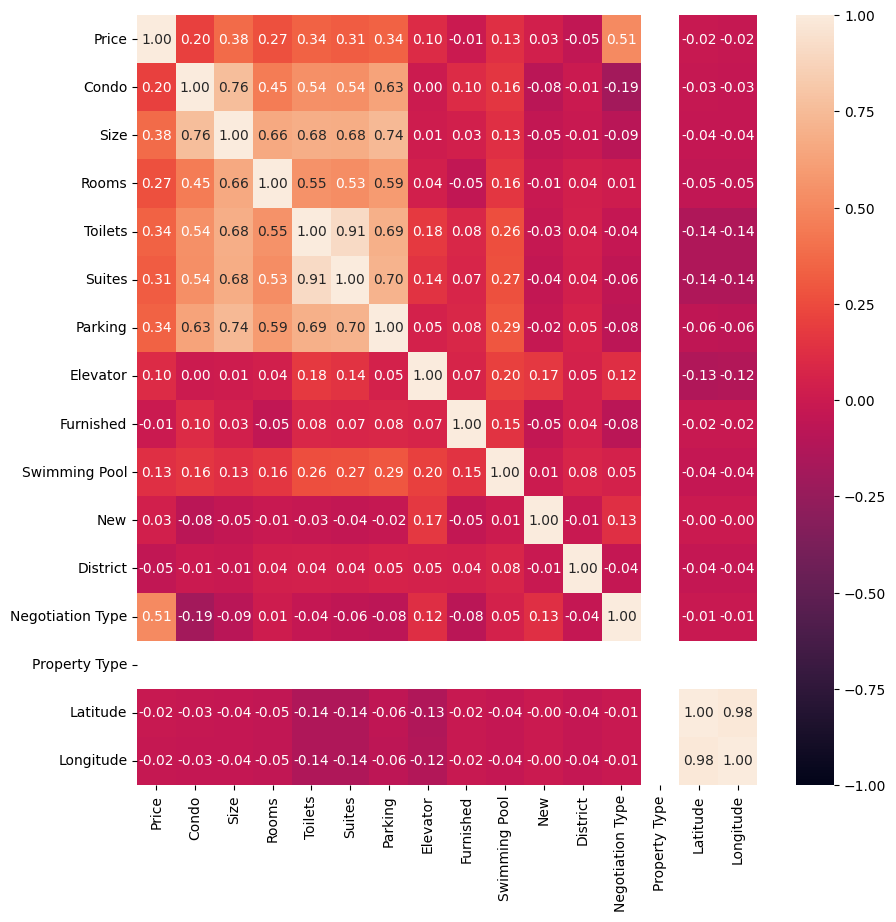

In [5]:
import seaborn as sb
import matplotlib.pyplot as plt

correlation = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(correlation, annot=True, square=False, vmin=-1, fmt='.2f', ax=ax)
plt.show()

## Divisão dos dados

In [6]:
x = df.iloc[:,:df.columns.size]
y = df.iloc[:,0]

## Definição dos algoritmos e pipelines

Aqui selecionamos três algoritmos para fazer os testes com a base de dados

* Multi Layer Processor Regressor
* Linear Regression
* Random Forest Regressor

Esses algoritmos foram selecionados baseados na literatura de apoio que pode ser consultada nas referências

Para cada um desses algoritmos definimos uma pipeline que inclui o pre-processador que definimos na etapa anterior, e tem como objetivo colocar os dados num formato mais adequado para o teinamento, e o algoritmo de regressão para ser processado logo após.

In [7]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), activation='relu', early_stopping=True, max_iter=1000)
mlp_pipe = Pipeline(steps=[('normalization', normalization), ('mlpc', mlp)])

rl = LinearRegression()
rl_pipe = Pipeline(steps=[('normalization', normalization), ('linear_reg', rl)])

rf = RandomForestRegressor()
rf_pipe = Pipeline(steps=[('normalization', normalization), ('randomforest', rf)])

rf_pipe


Pipeline(steps=[('normalization',
                 ColumnTransformer(transformers=[('normalize', StandardScaler(),
                                                  ['Price', 'Condo', 'Size',
                                                   'Rooms', 'Toilets', 'Suites',
                                                   'Parking', 'Elevator',
                                                   'Furnished', 'Swimming Pool',
                                                   'New', 'Latitude',
                                                   'Longitude', 'District',
                                                   'Negotiation Type',
                                                   'Property Type'])])),
                ('randomforest', RandomForestRegressor())])

## Treinamento e coleta de métricas

Aqui vamos utilizar a técnica de `k_fold` que consiste em dividir a base de dados em sessões (folds) e treinar de forma individual, dando uma maior distribuição no treinamento dos dados e permitindo identificar conjuntos que possuem um melhor resultado.

Definimos 5 repetições para que possamos identificar como esses treinamentos acontecem e sua consistencia a depender dos dados aleatoriamente selecionados em cada processo de fold.

Então para cada algoritmo vamos treinar e coletar as métricas escolhidas

* R2 Score
* RMSE- root mean squared error
* Tempo de execução

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import time

np.random.seed(seed=None)

repeat = 5
folds = 10

mlp_r2_values = []
mlp_rmse_values =[]
mlp_times = []

rl_r2_values = []
rl_rmse_values =[]
rl_times = []

rf_r2_values = []
rf_rmse_values =[]
rf_times = []

for i in range(repeat):
    kf = KFold(n_splits=folds, shuffle=True, random_state=repeat)

    start_time = time.time()
    # Treinamento da MLP
    for k, (train, test) in enumerate(kf.split(x)):
        x_train, x_test = x.iloc[train], x.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        mlp_pipe.fit(x_train, y_train)
        y_pred = mlp_pipe.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)

        mlp_r2_values.append(r2)
        mlp_rmse_values.append(rmse)

    end_time = time.time()
    mlp_times.append(end_time - start_time)

    start_time = time.time()
    # Treinamento da Regressao Linear
    for k, (train, test) in enumerate(kf.split(x)):
        start_time = time.time()
        x_train, x_test = x.iloc[train], x.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        rl_pipe.fit(x_train, y_train)
        y_pred = rl_pipe.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)

        rl_r2_values.append(r2)
        rl_rmse_values.append(rmse)

    end_time = time.time()
    rl_times.append(end_time - start_time)

    start_time = time.time()
    # Treinamento da Random Forest
    for k, (train, test) in enumerate(kf.split(x)):
        start_time = time.time()
        x_train, x_test = x.iloc[train], x.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        scaler = StandardScaler()
        scaler.fit(x_train)
        normalized_x_train = scaler.transform(x_train)
        normalized_x_test = scaler.transform(x_test)

        rf_pipe.fit(x_train, y_train)
        y_pred = rf_pipe.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)

        rf_r2_values.append(r2)
        rf_rmse_values.append(rmse)

    end_time = time.time()
    rf_times.append(end_time - start_time)

## Métricas

A partir desse momento, vamos mostrar algumas métricas coletadas a partir da execução dos algoritmos

In [9]:
import nbformat
import plotly.express as px

### R2 Score

Coeficiente de determinação: função de pontuação de regressão.

In [10]:
metrics_df = pd.DataFrame(data=[
    ['Rede Neural Artificial', np.mean(mlp_r2_values)],
    ['Regressão Linear', np.mean(rl_r2_values)],
    ['Random Forest', np.mean(rf_r2_values)]
  ],
  columns=['Algorithm', 'R2 Score'],
  
)
fig = px.bar(metrics_df, x='Algorithm', y='R2 Score', color='Algorithm')
fig.show()

### Raiz do Erro Quadrático Médio (RMSE)

A visualização da Raiz do Erro Quadrático Médio (Root Mean Squared Error - RMSE) mostra a diferença entre os valores preditos e os observados no modelo.

a função pode ser descrita por: $RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

In [11]:
metrics_df = pd.DataFrame(data=[
    ['Rede Neural Artificial', np.mean(mlp_rmse_values)],
    ['Regressão Linear', np.mean(rl_rmse_values)],
    ['Random Forest', np.mean(rf_rmse_values)]
  ],
  columns=['Algorithm', 'Root Mean Squared Error']
)
fig = px.bar(metrics_df, x='Algorithm', y='Root Mean Squared Error', color='Algorithm')
fig.show()

### Tempo de execução

Essa métrica é o tempo total de treinamento e avaliação de cada Algoritmo avaliado

In [12]:
metrics_df = pd.DataFrame(data=[
    ['Rede Neural Artificial', np.mean(mlp_times)],
    ['Regressão Linear', np.mean(rl_times)],
    ['Random Forest', np.mean(rf_times)]
  ],
  columns=['Algorithm', 'Time']
)
fig = px.bar(metrics_df, x='Algorithm', y='Time', color='Algorithm')
fig.show()